# Introduction
In the last tutorial notebook, I described the conventional approach for analyzing time-varying properties of neural oscillations, and in this notebook, we will go over our alternative approach. The fundamental goal of this approach is to characterize neural oscillations directly in the time domain. However, this is not straightforward because it attempts to extract the properties of the oscillatory component, despite the large amount of noise. Specifically, there are two very difficult problems:
1. What are the features of the oscillation? How do they vary over time?
2. During what times is the oscillation present?

The cycle-by-cycle approach deploys a few strategies to approach these questions. As its name indicates, this algorithm segments the signal into individual cycles and then analyzes their features separately from one another. Normally, some preprocessing is recommended to aid in localizing peaks and troughs (eliminating high frequency power that mostly do not comprise the oscillator of interest). Additionally, a burst detection approach is applied to define the segments of the signal to be analyzed for their oscillatory properties.

During this process (as with all data analyses), it is important to be aware if the data is being processed appropriately. As signal processing is complicated, it is very beneficial to visualize the measured features along with the raw data to assure they make sense.

# 0. Preprocess signal
A crucial part of the cycle-by-cycle approach is the ability to localize the peaks and troughs of the oscillation. Therefore, some preprocessing of the signal is often useful in order to make these extrema more apparent, i.e. isolate the oscillation component and minimize the nonoscillatory components. One effective way of doing this is by applying a lowpass filter. The choice of cutoff frequency is very important. The cutoff frequency should not be low enough in order to remove high frequency "noise" that interferes with extrema localization but not so low that it deforms the shape of the oscillation of interest. In order to assess this, the user should plot the filtered signal in comparison to the original signal.

(2, 5)

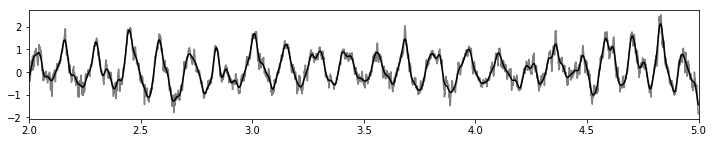

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from bycycle.filt import lowpass_filter
%matplotlib inline

signal = np.load('data/ca1.npy') / 1000
signal = signal[:125000]
Fs = 1250
f_theta = (4, 10)
f_lowpass = 30
N_seconds = .1

signal_low = lowpass_filter(signal, Fs, f_lowpass,
                            N_seconds=N_seconds, remove_edge_artifacts=False)


# Plot signal
t = np.arange(0, len(signal)/Fs, 1/Fs)
tlim = (2, 5)
tidx = np.logical_and(t>=tlim[0], t<tlim[1])

plt.figure(figsize=(12, 2))
plt.plot(t[tidx], signal[tidx], '.5')
plt.plot(t[tidx], signal_low[tidx], 'k')
plt.xlim(tlim)

# 1. Localize peaks and troughs
In order to characterize the oscillation, it is useful to know the precise times of peaks and troughs. For one, this will allow us to compute the periods and rise-decay symmetries of the individual cycles. To do this, the signal is first narrow-bandpass filtered in order to estimate "zero-crossings." Then, in between these zerocrossings, the absolute maxima and minima are found and labeled as the peaks and troughs, respectively.

In [2]:
from bycycle.filt import bandpass_filter
from bycycle.cyclepoints import _fzerorise, _fzerofall, find_extrema

# Narrowband filter signal
N_seconds_theta = .75
signal_narrow = bandpass_filter(signal, Fs, f_theta,
                                remove_edge_artifacts=False,
                                N_seconds=N_seconds_theta)

# Find rising and falling zerocrossings (narrowband)
zeroriseN = _fzerorise(signal_narrow)
zerofallN = _fzerofall(signal_narrow)

# Find peaks and troughs (this function also does the above)
Ps, Ts = find_extrema(signal_low, Fs, f_theta,
                      filter_kwargs={'N_seconds':N_seconds_theta})

(12, 15)

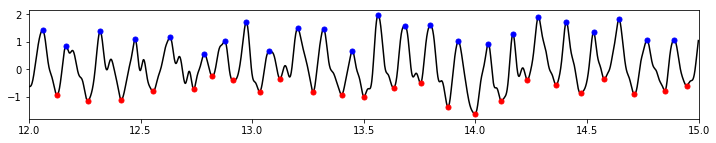

In [3]:
tlim = (12, 15)
tidx = np.logical_and(t>=tlim[0], t<tlim[1])
tidxPs = Ps[np.logical_and(Ps>tlim[0]*Fs, Ps<tlim[1]*Fs)]
tidxTs = Ts[np.logical_and(Ts>tlim[0]*Fs, Ts<tlim[1]*Fs)]

plt.figure(figsize=(12, 2))
plt.plot(t[tidx], signal_low[tidx], 'k')
plt.plot(t[tidxPs], signal_low[tidxPs], 'b.', ms=10)
plt.plot(t[tidxTs], signal_low[tidxTs], 'r.', ms=10)
plt.xlim(tlim)

### Note the filter characteristics used in the process of finding peaks and troughs

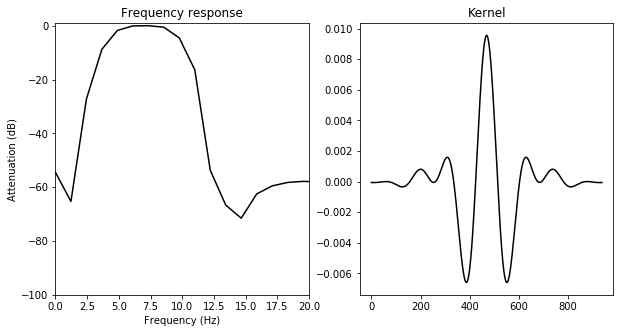

array([nan, nan, nan, ..., nan, nan, nan])

In [4]:
# Plot frequency response of bandpass filter
from bycycle.filt import bandpass_filter
bandpass_filter(signal, Fs, (4, 10), N_seconds=.75, plot_frequency_response=True)

# 2. Localize rise and decay midpoints
In addition to localizing the peaks and troughs of a cycle, we also want to get more information about the rise and decay periods. For instance, these flanks may have deflections if the peaks or troughs are particularly sharp. In order to gauge a dimension of this, we localize midpoints for each of the rise and decay segments. These midpoints are defined as the times at which the voltage crosses halfway between the adjacent peak and trough voltages. If this threshold is crossed multiple times, then the median time is chosen as the flank midpoint. This is not perfect; however, this is rare, and most of these cycles should be removed by burst detection.

In [5]:
from bycycle.cyclepoints import find_zerox
zeroxR, zeroxD = find_zerox(signal_low, Ps, Ts)

(13, 14)

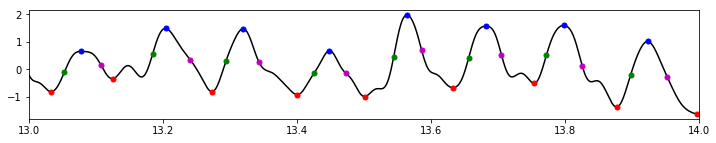

In [6]:
tlim = (13, 14)
tidx = np.logical_and(t>=tlim[0], t<tlim[1])
tidxPs = Ps[np.logical_and(Ps>tlim[0]*Fs, Ps<tlim[1]*Fs)]
tidxTs = Ts[np.logical_and(Ts>tlim[0]*Fs, Ts<tlim[1]*Fs)]
tidxDs = zeroxD[np.logical_and(zeroxD>tlim[0]*Fs, zeroxD<tlim[1]*Fs)]
tidxRs = zeroxR[np.logical_and(zeroxR>tlim[0]*Fs, zeroxR<tlim[1]*Fs)]

plt.figure(figsize=(12, 2))
plt.plot(t[tidx], signal_low[tidx], 'k')
plt.plot(t[tidxPs], signal_low[tidxPs], 'b.', ms=10)
plt.plot(t[tidxTs], signal_low[tidxTs], 'r.', ms=10)
plt.plot(t[tidxDs], signal_low[tidxDs], 'm.', ms=10)
plt.plot(t[tidxRs], signal_low[tidxRs], 'g.', ms=10)
plt.xlim(tlim)

# 3. Compute features of each cycle
After these 4 points of each cycle are localized, we compute some simple statistics for each cycle. The main cycle-by-cycle function, `compute_features()`, returns a table (pandas.DataFrame) in which each entry is a cycle and each column is a property of that cycle (see table below). There are columns to indicate where in the signal the cycle is located, but the four main features are:
1. amplitude (`volt_amp`) - average voltage change of the rise and decay
2. period (`period`) - time between consecutive troughs (or peaks, if default is changed)
3. rise-decay symmetry (`time_rdsym`) - fraction of the period in the rise period
4. peak-trough symmetry (`time_ptsym`) - fraction of the period in the peak period

Note that a warning appears here because no burst detection parameters are provided. This is addressed in section #4

In [7]:
from bycycle.features import compute_features

df = compute_features(signal, Fs, f_theta)

df.head()

/gh/bv/bycycle/bycycle/features.py:104: UserWarning: 
            No burst detection parameters are provided.
            This is very much not recommended.
            Please inspect your data and choose appropriate
            parameters for "burst_detection_kwargs".
            Default burst detection parameters are likely
            not well suited for your desired application.
            
  ''')


,sample_peak,sample_zerox_decay,sample_zerox_rise,sample_last_trough,sample_next_trough,period,time_peak,time_trough,volt_peak,volt_trough,...,volt_rise,volt_amp,time_rdsym,time_ptsym,band_amp,amp_fraction,amp_consistency,period_consistency,monotonicity,is_burst
0,615,663,575,519,743,224,88,111,1.195,-1.258,...,2.453,2.3595,0.428571,0.442211,0.570788,0.423620,NaN,NaN,0.633444,False
1,819,882,771,743,914,171,111,108,0.521,-1.071,...,1.592,1.2980,0.444444,0.506849,0.355844,0.002567,0.630653,0.763393,0.584539,False
2,1002,1026,937,914,1056,142,89,55,1.093,-0.483,...,1.576,1.8865,0.619718,0.618056,0.686511,0.077022,0.637056,0.830409,0.647907,False
3,1131,1174,1101,1056,1214,158,73,75,1.791,-1.104,...,2.895,2.5945,0.474684,0.493243,0.680391,0.643132,0.758895,0.887640,0.604812,False
4,1273,1331,1229,1214,1392,178,102,55,1.758,-0.503,...,2.261,2.4725,0.331461,0.649682,0.654177,0.537869,0.762668,0.691011,0.607101,False


# 4. Determine parts of signal in oscillatory burst
Note above that the signal is segmented into cycles and the dataframe provides properties for each segment of the signal. However, if no oscillation is apparent in the signal at a given time, the properties for these "cycles" are meaningless. Therefore, it is useful to have a binary indicator for each cycle that indicates whether the cycle being analyzed is truly part of an oscillatory burst or not. Recently, significant interest has emerged in detecting bursts in signals and analyzing their properties (see e.g. [Feingold et al., PNAS, 2015](http://www.pnas.org/content/112/44/13687)). Nearly all efforts toward burst detection relies on amplitude thresholds, but this can be disadvantageous because these algorithms will behave very differently on signals where oscillations are common versus rare.

In our approach, we employ an alternative technique for burst detection. There are 3 thresholds that need to be met in order for a cycle to be classified as part of an oscillatory burst.
1. amplitude consistency - consecutive rises and decays should be comparable in magnitude.
    * The amplitude consistency of a cycle is equal to the maximum relative difference between rises and decay amplitudes across all pairs of adjacent rises and decays that include one of the flanks in the cycle (3 pairs)
    * e.g. if a rise is 10mV and a decay is 7mV, then its amplitude consistency is 0.7.
2. period consistency - consecutive cycles should be comparable in duration
    * The period consistency is equal to the maximu relative difference between all pairs of adjacent periods that include the cycle of interest (2 pairs: current + previous cycles and current + next cycles)
    * e.g. if the previous, current, and next cycles have periods 60ms, 100ms, and 120ms, respectively, then the period consistency is min(60/100, 100/120) = 0.6.
3. monotonicity - the rise and decay flanks of the cycle should be mostly monotonic
    * The monotonicity is the fraction of samples that the instantaneous derivative (numpy.diff) is consistent with the direction of the flank.
    * e.g. if in the rise, the instantaneous derivative is 90% positive, and in the decay, the instantaneous derivative is 80% negative, then the monotonicity of the cycle would be 0.85 ((0.9+0.8)/2)
    
Below, we simulate a signal and then define 3 sets of thresholds ranging from liberal to conservative.

### Simulate signal with a bursting oscillator and noise

In [8]:
from bycycle.sim import sim_noisy_bursty_oscillator
np.random.seed(0)
cf = 7
f_theta = (4,10)
T = 10
Fs = 1000
signal = sim_noisy_bursty_oscillator(T, Fs, cf, prob_enter_burst=.1,
                                     prob_leave_burst=.1, SNR=5,
                                     cycle_features={'rdsym_mean':.3})
signal = lowpass_filter(signal, Fs, 25, N_seconds=.2, remove_edge_artifacts=False)

### Visualizing burst detection settings
Below, we visualize how the burst detector determined which cycles were part of an oscillatory burst. The top plot shows a markup of the time series. The portions of the signal in red were determined to be parts of bursts. Signals in black were not part of bursts. Magenta and cyan dots denote detected peaks and troughs, respectively. Highlights indicate cycles marked as not part of a burst because they did not meet certain thresholds:
* red highlight: amplitude consistency threshold violation
* yellow highlight: period consistency threshold violation
* green highlight: monotonicity threshold violation
The plots below show the relevant features for each cycle as well as the threshold (dotted lines), where we can see the highlights appear if the features went below the threshold.

Note there is an optional "band amplitude fraction" threshold. This is currently unused (set to 0), but is present in case users want to add an amplitude threshold to this algorithm.

### Burst detection settings: too liberal
The following burst detection thresholds (defined in `burst_kwargs`) are too low, so some portions of the signal that do not have much apparent oscillatory burst are still labeled as if they do.

/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


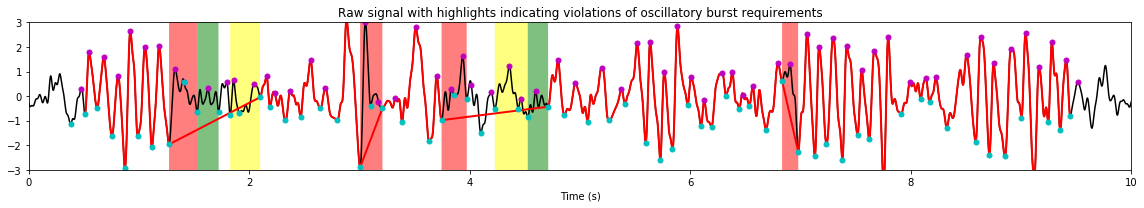

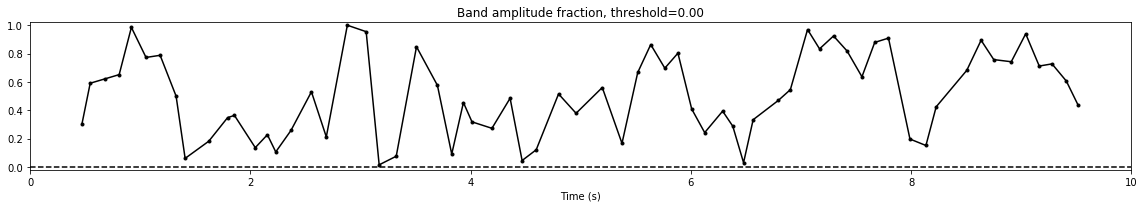

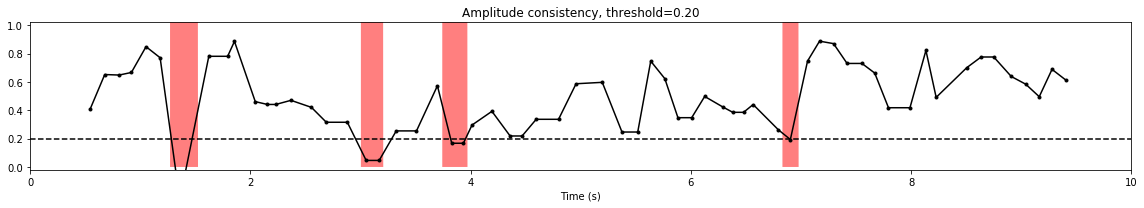

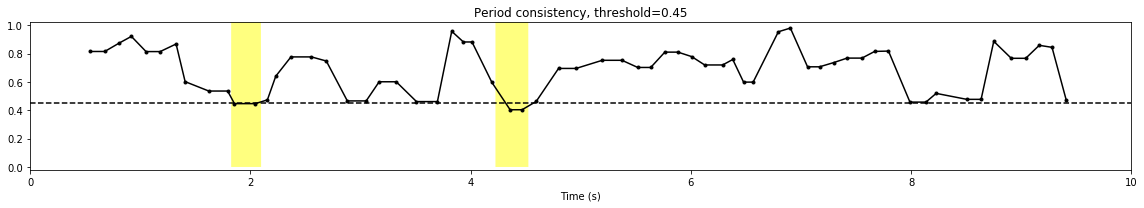

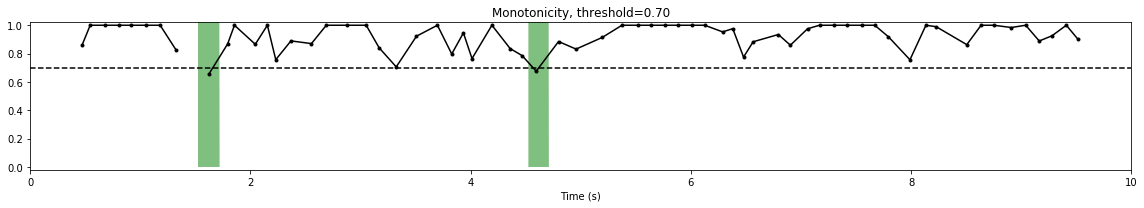

In [9]:
from bycycle.burst import plot_burst_detect_params

burst_kwargs = {'amplitude_fraction_threshold': 0,
                'amplitude_consistency_threshold': .2,
                'period_consistency_threshold': .45,
                'monotonicity_threshold': .7,
                'N_cycles_min': 3}

df = compute_features(signal, Fs, f_theta, burst_detection_kwargs=burst_kwargs)

plot_burst_detect_params(signal, Fs, df, burst_kwargs,
                         tlims=None, figsize=(16, 3))

### Burst detection settings: too conservative
These new burst detection thresholds seem to be set too high (too strict) as the algorithm is not able to detect the bursts that are present.

/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


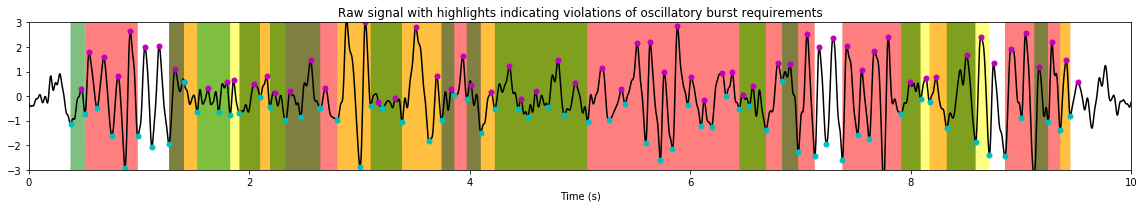

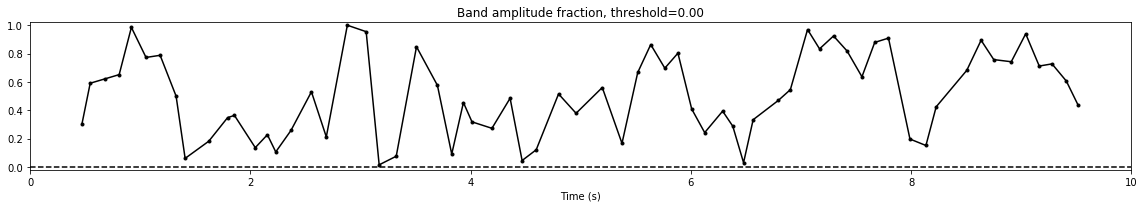

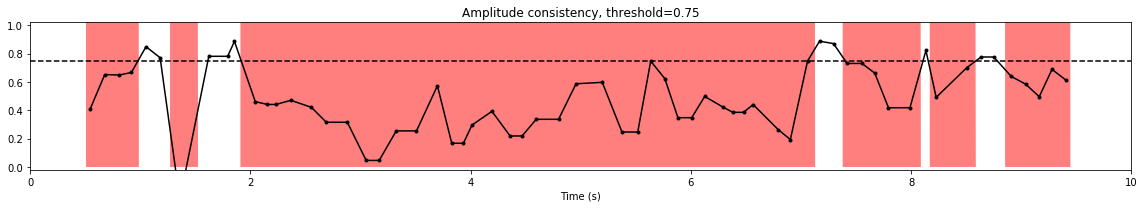

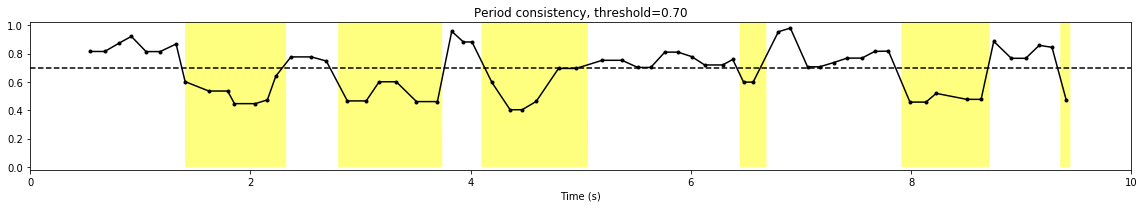

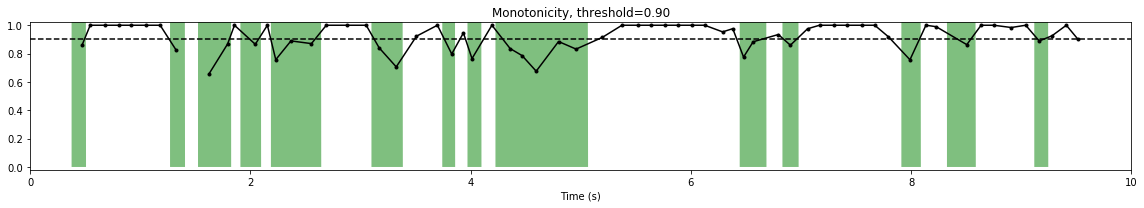

In [10]:
burst_kwargs = {'amplitude_fraction_threshold': 0,
                'amplitude_consistency_threshold': .75,
                'period_consistency_threshold': .7,
                'monotonicity_threshold': .9,
                'N_cycles_min': 3}

df = compute_features(signal, Fs, f_theta, burst_detection_kwargs=burst_kwargs)

plot_burst_detect_params(signal, Fs, df, burst_kwargs,
                         tlims=None, figsize=(16, 3))

### More appropriate burst detection thresholds
The conservative thresholds were then lowered, and we can see now that the algorithms correctly identifies parts of the 3 bursting periods. Therefore, for a signal with this level of noise, we expect these parameters to be pretty good.

/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


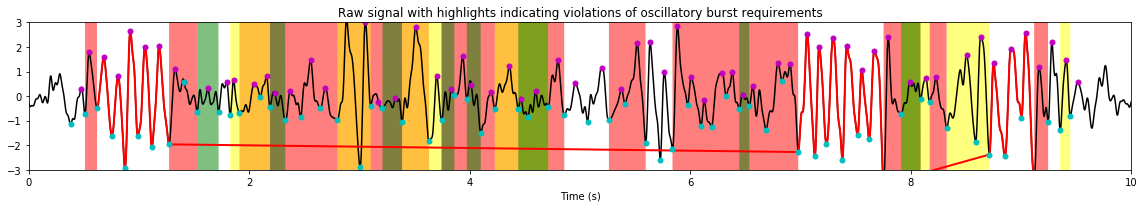

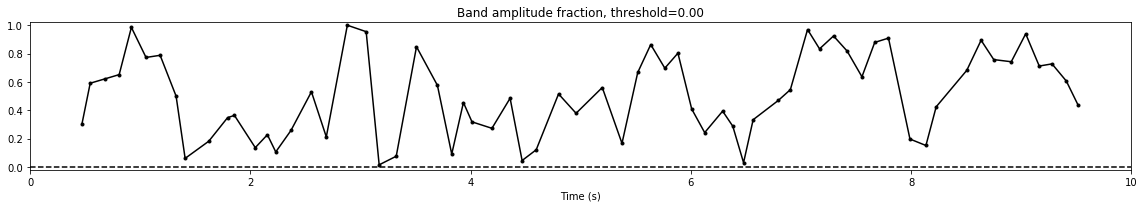

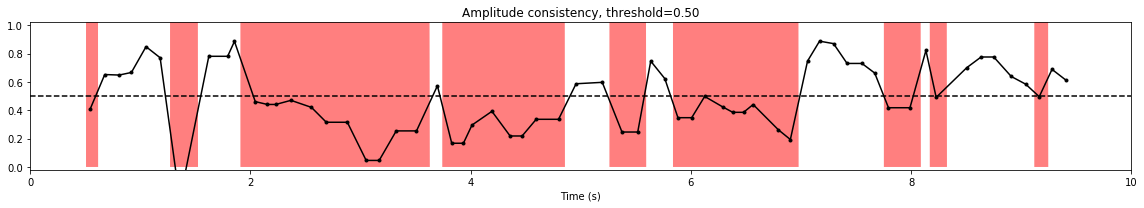

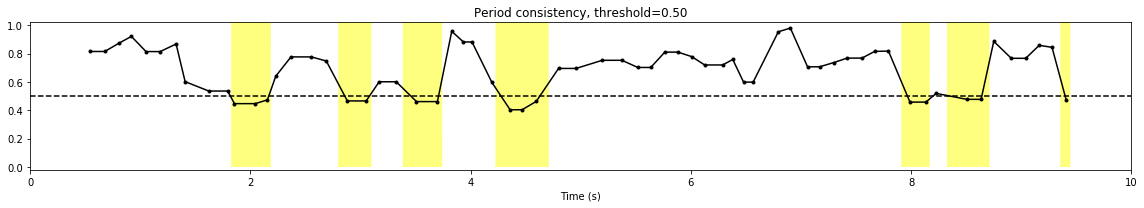

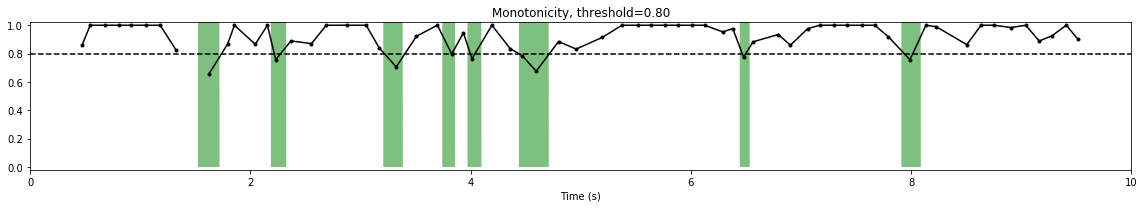

In [11]:
burst_kwargs = {'amplitude_fraction_threshold': 0,
                'amplitude_consistency_threshold': .5,
                'period_consistency_threshold': .5,
                'monotonicity_threshold': .8,
                'N_cycles_min': 3}

df = compute_features(signal, Fs, f_theta, burst_detection_kwargs=burst_kwargs)

plot_burst_detect_params(signal, Fs, df, burst_kwargs,
                         tlims=None, figsize=(16, 3))